# Metropolis Hastings

## Part A: MH Proposals and Acceptance Probabilities

> *Starting with a very general notation...*

Accepting draws from a ***proposal distribution*** 

$\tilde x^{(t)} \sim q(\tilde x^{(t)}|x^{(t-1)})$

according to 

$$x^{(t)} = \left\{\begin{array}{ll}
\tilde x^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde x^{(t)})}{p(x^{(t-1)})}\frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})}\right) \quad \color{gray}{\begin{array}{c}\textrm{... is the normalizing constant needed for $p$?}\\\textrm{... and what happens if $q$ is symmetric?}  \end{array}}\\
x^{(t-1)} & \text{otherwise}
\end{array}\right.$$

will produce draws from $p(x^{(t)})$.

### This is a two step conditional process 

$$
\begin{align*}
&\quad\, \Pr(\textrm{accept}|\textrm{proposal},\textrm{current state}) p(\textrm{proposal}|\textrm{current state})\\ 
&={}
\Pr(\textrm{accept}|\textrm{proposal}) p(\textrm{proposal}|\textrm{current state})\\
&={} \Pr(x^{(t)} = \tilde x^{(t)}) q(\tilde x^{(t)}|x^{(t-1)})
\end{align*}
$$

### Does it work?

Let's see for 

$$
\begin{align*}
p(x^{(t)}) & \rightarrow {} N(0,1)\\
q(\tilde x^{(t)}|x^{(t-1)}) & \rightarrow {} N(x^{(t-1)},\sigma)
\end{align*}
$$


Rejection rate: 0.03


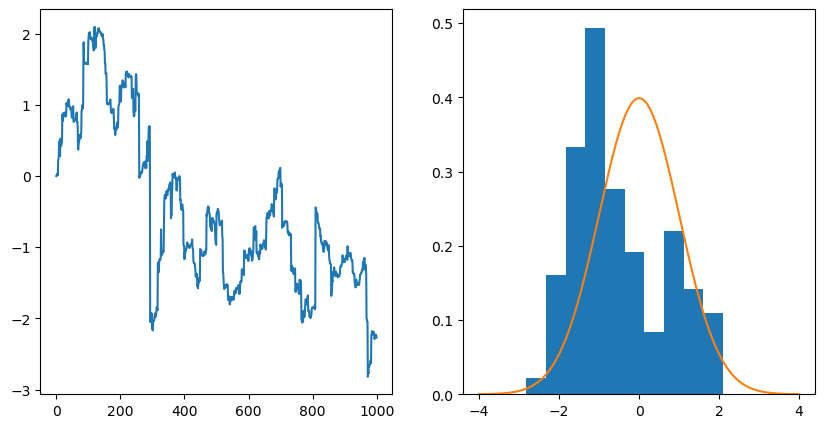

In [2]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

p_x_pdf = lambda x: stats.norm().pdf(x)
mh_tuning_parameter = 50
q_xt_given_xtm1 = lambda x: stats.norm(x, scale=mh_tuning_parameter)

proposal_distribution = q_xt_given_xtm1
# try new proposal distribution other than normal
proposal_distribution = lambda x: stats.cauchy(x, scale=1/mh_tuning_parameter)

m = 1000
x = np.zeros(m)
rejections = 0
for t in range(1,m):
    x_tilde = proposal_distribution(x[t-1]).rvs()
    acceptance_probability = min(1, p_x_pdf(x_tilde)/p_x_pdf(x[t-1])) 
    # Metropolis-Hastings acceptance probability, you technically need correction weights from q, but it is canceled here because its symmetric
    if stats.uniform().rvs() < acceptance_probability:
        x[t] = x_tilde
    else:
        x[t] = x[t-1]
        rejections += 1

fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(x)
ax[1].hist(x, density=True)
x_support = np.linspace(-4,4,301)
ax[1].plot(x_support, p_x_pdf(x_support));
print(f"Rejection rate: {rejections/m}")

# reduce dependency from previous sample => increase tuning parameter OR increase number of samples


## Part B: What is MH?


### Why doesn't this work?


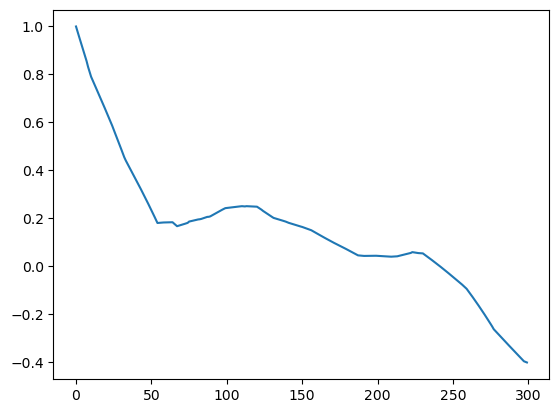

In [88]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]
# correlation between 1st step and 2nd step, 1st step and 3rd step, 1st step and 4th step, ... decays!
plt.plot(autocorrelations);

### Effective sample size

$$n_{\text{eff}} = \frac{m}{\sum_{k=-\infty}^\infty\rho_k} = \frac{m}{1+2\sum_{k=1}^\infty\rho_k} \quad \text{ for order $k$ autocorrelations } \quad \rho_k $$

which is based on the relative value of $m$ between
- $\textrm{Var}\left({\sum_{t=1}^m x^{(t)}}\right) = m \sigma^2$ under i.i.d. sampling and the actual 
- $\textrm{Var}\left(\sum_{t=1}^m x^{(t)}\right) = \sum_{t=1}^m \textrm{Var}\left(x^{(t)}\right) + \sum_{t \neq t'} \textrm{Cov}(x^{(t)},x^{(t')}) = m \sigma^2 + \sum_{t \neq t'} \sigma^2 \rho_{t,t'} \approx m \sigma^2+2m \sigma^2 \sum_{k=1}^m\rho_k \approx m \sigma^2+2m \sigma^2 \sum_{k=1}^\infty\rho_k $


In [89]:
m / (1 + 2*autocorrelations[:100].sum())

12.612218564446119

Effective sample size: 8.799104772808228


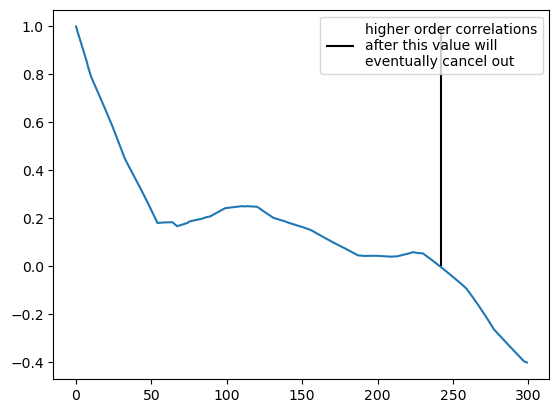

In [90]:
K = 300
autocorrelations = np.ones(K)
for t_plus_k in range(1, K):
    autocorrelations[t_plus_k] = np.corrcoef(x[:-t_plus_k], x[t_plus_k:])[0,1]

approximation_stop = (autocorrelations < 0).cumsum()
approximation_stop = approximation_stop*np.arange(K)
approximation_stop = min(approximation_stop[approximation_stop>0])

plt.plot(autocorrelations) 
plt.vlines(approximation_stop, ymin=0, ymax=1, color='k',
           label='higher order correlations\nafter this value will\neventually cancel out')
plt.legend()
# effective sample size
m / (1 + 2*autocorrelations[:approximation_stop].sum())
print(f"Effective sample size: {m / (1 + 2*autocorrelations[:approximation_stop].sum())}")

### Rejection Rate

The **rejection rate** of the **Metropolis Hastings** algorithm given above is something else that we should keep in mind.

#### Q1: Is a high rejection rate benefiicial or detrimental for the effective sample size calculation?

#### Q2: What is the relationship between the proposal distribution and the rejection rate?

In [91]:
rejections/m
# Is a high rejection rate benefiicial or detrimental for the effective sample size calculation?
# It is detrimental, because the effective sample size is calculated as the number of samples divided by 1 + 2*sum of autocorrelations. 
# A high rejection rate will increase the denominator, which will decrease the effective sample size.

# What is the relationship between the proposal distribution and the rejection rate?
# The rejection rate is dependent on the proposal distribution. A good proposal distribution will have a lower rejection rate.

0.98

### Why does this work?

> *Changing and hinting with the the notation to begin being suggestive about our purposes...*

If we have a **stationary distribution** $p(\theta \color{gray}{|x})$ then **transition distribution (kernel)** $q$ produces a sample from this **stationary distribution** if the ***Markov chain*** it produces is ***reversible***.

$$
\begin{align*}
p(\theta^{(t)}|\theta^{(t-1)})p(\theta^{(t-1)}\color{gray}{|x}) & = {}  p(\theta^{(t-1)}|\theta^{(t)})p(\theta^{(t)}\color{gray}{|x})\\\\
& \textrm{But is this true if we use a Metropolis-Hastings transition distribution (kernel)?}
\\\\
p(\theta^{(t)}\color{gray}{|x}) & \overset{MH}{=} {} \frac{\alpha_{\textrm{accept prob}}^{\textrm{forward}} q(  \theta^{(t)}| \theta^{(t-1)})}{\alpha_{\textrm{accept prob}}^{\textrm{backward}} q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{\min\left(1,\frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})}\right) q( \theta^{(t)}|\theta^{(t-1)})}{\min\left(1,\frac{p( \theta^{(t-1)}\color{gray}{|x})}{p( \theta^{(t)}\color{gray}{|x})}\frac{q( \theta^{(t)}| \theta^{(t-1)})}{q( \theta^{(t-1)}| \theta^{(t)})}\right) q(  \theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x})\\\\
& \textrm{The fractions in the "$\min$" in the numerator or denomenator are reciprocals}\\
& \textrm{thus regardless of if the numerator fraction is equal to, greater than, or less than $1$}\\\\
p( \theta^{(t)}\color{gray}{|x}) & = {} \frac{p( \theta^{(t)}\color{gray}{|x})}{p(\theta^{(t-1)}\color{gray}{|x})}\frac{q(\theta^{(t-1)}| \theta^{(t)})}{q( \theta^{(t)}|\theta^{(t-1)})} \frac{q\theta^{(t)}|\theta^{(t-1)})}{q(\theta^{(t-1)}|\theta^{(t)})}p(\theta^{(t-1)}\color{gray}{|x}) \\\\
\xcancel{p( \theta^{(t)}\color{gray}{|x})} & = {} \frac{\xcancel{p(\theta^{(t)}\color{gray}{|x})}}{\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}}\frac{\cancel{q(\theta^{(t-1)}| \theta^{(t)})}}{\cancel{q( \theta^{(t)}|\theta^{(t-1)})}} \frac{\cancel{q\theta^{(t)}|\theta^{(t-1)})}}{\cancel{q(\theta^{(t-1)}|\theta^{(t)})}}\xcancel{p(\theta^{(t-1)}\color{gray}{|x})}\\  \longrightarrow \quad 1 & ={} 1 \quad \textrm{ so the equation is true and reversibility holds}
\end{align*}$$

So **Metropolis-Hastings** creates a **reversible Markov Chain** whose **stationary distribution** is the **target** of the **Metropolis-Hastings** algorithm

## Part C: Back to Gibbs sampling

**Gibbs sampling** also creates a **reversible Markov Chain** whereby the samples, forwards or backwards, are from the same **stationary distribution** (which is the **joint posterior distribution** of the (random. variable) parameters of the **full conditional (posterior) distributions**


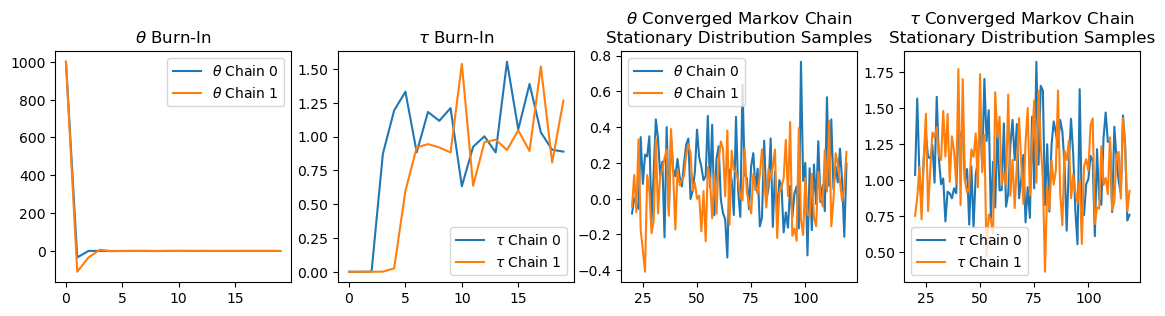

In [95]:
# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        tau[c,g] = \
        stats.gamma(a=n/2+1, 
                    scale=2/((x-theta[c,g-1])**2).sum()).rvs()
        theta[c,g] = \
        stats.norm(x.mean(), 
                   scale=1/np.sqrt(tau[c,g]*n)).rvs()

fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

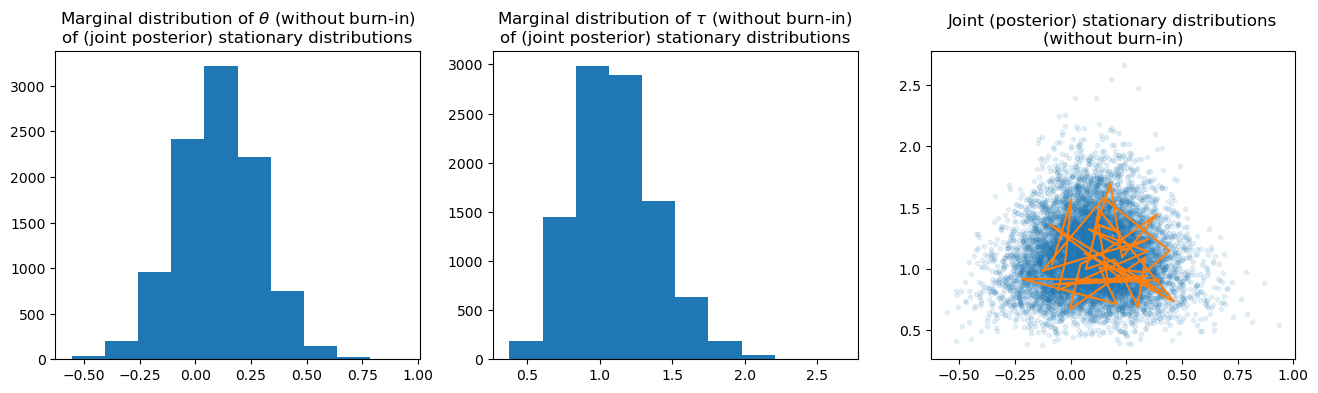

In [96]:
fig,ax = plt.subplots(1, 3, figsize=(16,4))
ax[0].set_title("Marginal distribution of $\\theta$ (without burn-in)\nof (joint posterior) stationary distributions")
ax[1].set_title("Marginal distribution of $\\tau$ (without burn-in)\nof (joint posterior) stationary distributions")
ax[2].set_title("Joint (posterior) stationary distributions\n(without burn-in)")

ax[0].hist(theta[0,burn:])
ax[1].hist(tau[0,burn:])
ax[2].plot(theta[0,burn:], tau[0,burn:], '.', alpha=0.1);
demo = 3*burn
ax[2].plot(theta[0,burn:demo], tau[0,burn:demo]);

## Metropolis within Gibbs

1. All **full conditional distributions** are proportional to the **joint**.
2. A **Metropolis-Hastings** step can sample from a **full conditional** by proposing a sample and accepting it according to the MH acceptance probability.
3. The target density in the MH acceptance probability appears in the numerator and denomenator so it's normalizing constants cancel and all that's needed 

Accepting draws from a ***proposal distribution*** 

$\tilde \theta^{(t)} \sim q(\tilde \theta^{(t)}|\theta^{(t-1)})$

according to 

$$
\theta^{(t)} = \left\{\begin{array}{ll}
\tilde \theta^{(t)} & \text{with probability } \min\left(1,\frac{p(\tilde \theta^{(t)}|\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)}|\tau^{(t)},\mathbf{x})}\frac{q(\theta^{(t-1)}|\tilde \theta^{(t)})}{q(\tilde \theta^{(t)}|\theta^{(t-1)})}\right) = \min\bigg(1,\frac{p(\tilde \theta^{(t)},\tau^{(t)},\mathbf{x})}{p(\theta^{(t-1)},\tau^{(t)},\mathbf{x})}\overset{\textrm{if symmetric}}{\cancel{\frac{q(\theta^{(t-1)}|\tilde \theta^{(t)})}{q(\tilde \theta^{(t)}|\theta^{(t-1)})}}^1}\bigg) \\
\theta^{(t-1)} & \text{otherwise}\\\\
\end{array}\right.$$

will produce draws from $p(\theta^{(t)}|\tau^{(t)},\mathbf{x})$.

And an analogous **Metropolis within Gibbs** step exists for $\tau^{(t)}$. 


## Homework

---

### Q1

Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
- Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
    - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
- Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
- When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

*Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*

### Q2

Adjust your **Metropolis within Gibbs** sampler as follows.

- Use the following **dependent** proposal for $\tau$

```Python
stats.truncnorm(a=-tau_t_minus_1/s, b=np.Inf,
                loc=tau_t_minus_1, scale=s)
```

- Use a prior for $\theta$ that is not a normal distribution 


*Provide a demonstration showing the Bayesian inference provided by this sampler. Then discuss the necessity (or lackthereof)  of analytically determining the full conditional distributions when using Metropolis-Hastings.*

### Q3 

For **Metropolis Hastings** targetting (**stationary distribution**) $p$ based on proposal distribuiton $q$ given below

$\begin{align}
q(\tilde x^{(t)} | x^{(t-1)}) &={} \left(\frac{1}{2}\right)^{1-{\tilde x^{(t)}}}\left(\frac{1}{2}\right)^{\tilde x^{(t)}} \quad \color{gray}{\textrm{ ... does } \quad \frac{q(x^{(t-1)}|\tilde x^{(t)})}{q(\tilde x^{(t)}|x^{(t-1)})} \quad  \textrm{ cancel?}}\\
\textrm{and} \quad p(x^{(t)}) &={} \left(\frac{1}{3}\right)^{1-{x^{(t)}}}\left(\frac{2}{3}\right)^{x^{(t)}}\\
\end{align}$

<u>show that</u> the **transition kernel** $K$ of transition probabilities is defined the **Metropolis Hastings** algorithm is

$K = \left[\begin{array}{cc}\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=0) & \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=0)\\\Pr(x^{(t)}=0 \rightarrow x^{(t+1)}=1)& \Pr(x^{(t)}=1 \rightarrow x^{(t+1)}=1)\end{array}\right] = \left[\begin{array}{cl} 0.5 & 0.25 \\ 0.5 & 0.75 \end{array}\right]$


In [102]:
# Convert your **Gibbs sampler** from the previous homework to be a **Metropolis within Gibbs** sampler. 
# - Do not derive any full conditionals and instead just use the joint distribution which is the product of the likelihood with the priors 
#     - Note that in fact you must only be proportional to the joint since irrelevant priors of "the other parameter" will cancel in the ratio
# - Note that $\tau$ must be positive so proposals $\tilde \tau$ must also be positive. The easiest way to achieve this would be to use independent samples (that do not depend on $\tau^{(t-1)}$ from exponential, half normal, gamma, or inverse gamma distributions (and other distributions defining strictly positive random variables).
# - When considering using independent proposal distributions one option of some note is to use the prior $p(\tau)$ as this proposal distribution

# *Clearly articulate your specification and provide a demonstration showing the Bayesian inference it provides, in contrast to that of your previous Gibbs sampler (of Q2 from the last homework).*



# loc is mean and scale is standard deviation
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,10000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = 1000  # initialization
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        
        # as a function of tau, the likelihood *prior of tau is proportional to the joint distribution
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale = 1/(tau_**0.5)).pdf(x)) * stats.expon(scale=1).pdf(tau_)

        tau_proposal = stats.expon(scale=2)
        tau_tilde = tau_proposal.rvs()

        mh_calculation = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * ((tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde)))
        acceptance_probability = min(1, mh_calculation)
        
        if stats.uniform().rvs() < acceptance_probability:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]


        # as a function of theta, the likelihood *prior of theta is proportional to the joint distribution
        theta_target = lambda theta_: np.prod(stats.norm(loc=theta_, scale = 1/(tau[c,g]**0.5)).pdf(x)) * stats.norm(loc=0, scale=1).pdf(theta_)
        
        theta_proposal = stats.norm(loc=theta[c, g-1], scale=1)
        theta_tilde = theta_proposal.rvs()

        mh_calculation = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * ((theta_proposal.pdf(theta[c, g-1]) / theta_proposal.pdf(theta_tilde)))
        acceptance_probability = min(1, mh_calculation)

        if stats.uniform().rvs() < acceptance_probability:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]





/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_8397/4167251153.py:21: RuntimeWarning: divide by zero encountered in scalar divide
  tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c, g-1], scale = 1/(tau_**0.5)).pdf(x)) * stats.expon(scale=1).pdf(tau_)
/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_8397/4167251153.py:25: RuntimeWarning: invalid value encountered in scalar divide
  mh_calculation = (tau_target(tau_tilde) / tau_target(tau[c, g-1])) * ((tau_proposal.pdf(tau[c, g-1]) / tau_proposal.pdf(tau_tilde)))
/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_8397/4167251153.py:39: RuntimeWarning: invalid value encountered in scalar divide
  mh_calculation = (theta_target(theta_tilde) / theta_target(theta[c, g-1])) * ((theta_proposal.pdf(theta[c, g-1]) / theta_proposal.pdf(theta_tilde)))
/var/folders/vd/j_d7xxb56hg064_h1h3mkqt80000gn/T/ipykernel_8397/4167251153.py:25: RuntimeWarning: divide by zero encountered in scalar divide
  mh_calculation =

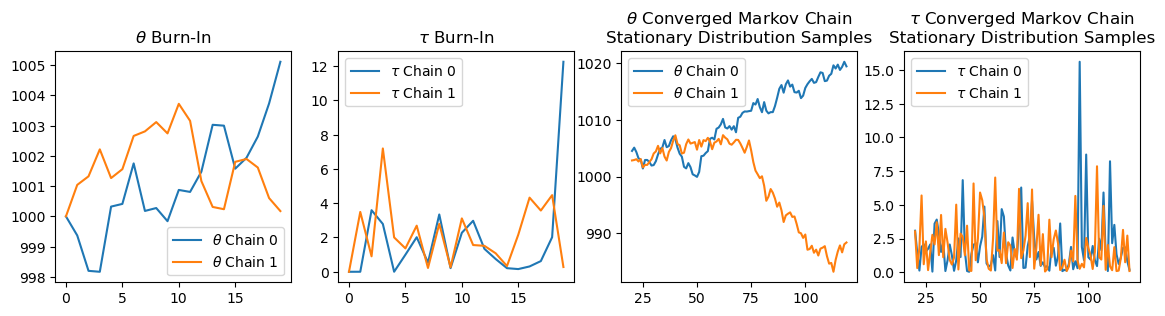

In [103]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 120
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

This means that

- if we're currently a $0$ there's a 50\% chance that we'll stay a $0$ and 50\% chance that we'll change to a $1$
- and if we're currently a $1$ there's a 75\% chance that we'll stay a $1$ and 25\% chance that we'll change to a $0$

which specifies [geometric distributions](https://en.wikipedia.org/wiki/Geometric_distribution) with, respectively, expected values of $1$ and $3$ "failures before transitioning to the other state" which means that on average a "$0$ state" will be a run of two $0$'s while a "$1$ state" will be a run of four $1$'s which leads to the desired one-to-two (or one-thirds to two-thirds) ratio of $0$'s and $1$ is the Markov Chain. 


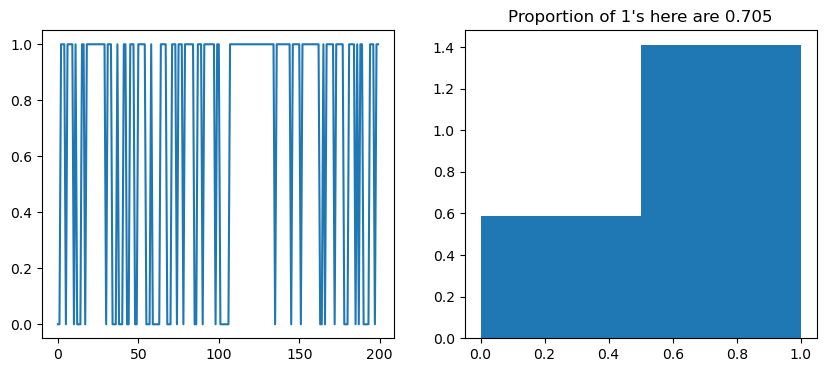

In [97]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by A sequentially
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
K = np.array([[.5,.25],[.5,.75]]) 
T = 200
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].plot(s_t)
ax[1].hist(s_t, bins=2, density=True)
ax[1].set_title("Proportion of 1's here are "+str(s_t.mean()));

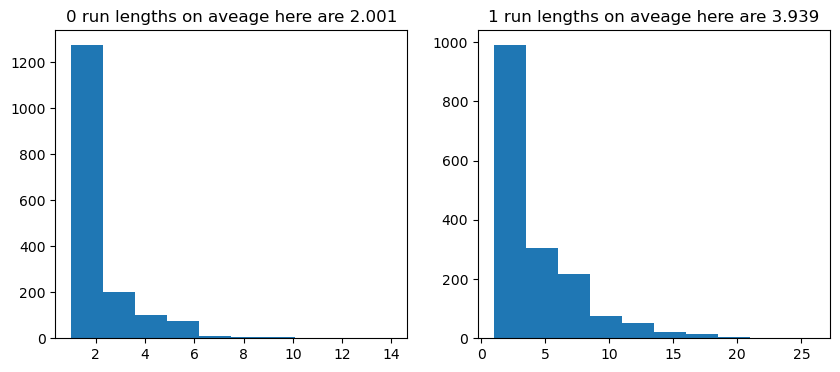

In [98]:
# Here's what it looks like if we flip coins  
# with transition probabilties defind by K 
# and sure enough we recover 1/3 and 2/3 for 0 and 1 respectively
T = 10000
s_t = np.zeros(T, dtype=int)
for t in range(1, T):
    s_t[t] = int(stats.uniform().rvs() < K[:,s_t[t-1]][1])
    
state0_run_length = []
state1_run_length = []
run_length = 1
for t in range(1,T):
    if s_t[t]==s_t[t-1]:
        run_length += 1
    else:
        if s_t[t-1] == 0:
            state0_run_length += [run_length]
        else:
            state1_run_length += [run_length]        
        run_length = 1
        
fig,ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].hist(state0_run_length)
ax[0].set_title("0 run lengths on aveage here are "+str(np.mean(state0_run_length).round(3)))
ax[1].hist(state1_run_length)
ax[1].set_title("1 run lengths on aveage here are "+str(np.mean(state1_run_length).round(3)));
